In [1]:
import sys
sys.path.append("../")
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"

import torch
import torch.nn as nn
import numpy as np

from HyperSINDy import Net
from baseline import Trainer
from library_utils import Library
from Datasets import SyntheticDataset
from other import init_weights, make_folder, set_random_seed

from exp_utils import get_equations

import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate

sns.set()

In [2]:
def load_test_data(data_folder):
    x1 = np.array([np.load(data_folder + "lorenz/scale-1.0/x_test_0.npy"),
                   np.load(data_folder + "lorenz/scale-1.0/x_test_1.npy")])
    x2 = np.array([np.load(data_folder + "lorenz/scale-5.0/x_test_0.npy"),
                   np.load(data_folder + "lorenz/scale-5.0/x_test_1.npy")])
    x3 = np.array([np.load(data_folder + "lorenz/scale-10.0/x_test_0.npy"),
                   np.load(data_folder + "lorenz/scale-10.0/x_test_1.npy")])
    return [x1, x2, x3]

def load_model(device, z_dim, poly_order, include_constant,
               noise_dim, hidden_dim, stat_size, batch_size,
               cp_path):

    torch.cuda.set_device(device=device)
    device = torch.cuda.current_device()

    library = Library(n=z_dim, poly_order=poly_order, include_constant=include_constant)

    net = Net(library, noise_dim=noise_dim, hidden_dim=hidden_dim,
              statistic_batch_size=stat_size, num_hidden=num_hidden).to(device)
    net.get_masked_coefficients(batch_size=batch_size, device=device)

    cp = torch.load(cp_path, map_location="cuda:" + str(device)) 
    net.load_state_dict(cp['model'])
    net.to(device)
    net = net.eval()
    
    return net, library, device

#https://github.com/urban-fasel/EnsembleSINDy
def fourth_order_diff(x, dt):
    dx = np.zeros([x.shape[0], x.shape[1]])
    dx[0] = (-11.0 / 6) * x[0] + 3 * x[1] - 1.5 * x[2] + x[3] / 3
    dx[1] = (-11.0 / 6) * x[1] + 3 * x[2] - 1.5 * x[3] + x[4] / 3
    dx[2:-2] = (-1.0 / 12) * x[4:] + (2.0 / 3) * x[3:-1] - (2.0 / 3) * x[1:-3] + (1.0 / 12) * x[:-4]
    dx[-2] = (11.0 / 6) * x[-2] - 3.0 * x[-3] + 1.5 * x[-4] - x[-5] / 3.0
    dx[-1] = (11.0 / 6) * x[-1] - 3.0 * x[-2] + 1.5 * x[-3] - x[-4] / 3.0
    return dx / dt 

In [3]:
def sample_hypersindy(net, library, device, x0, batch_size=10, dt=1e-2, ts=10000):
    set_random_seed(SEED)
    zc = torch.from_numpy(x0).type(torch.FloatTensor).to(device).unsqueeze(0)
    zc = zc.expand(batch_size, -1)
    zs = []
    for i in range(ts):
        coefs = net.get_masked_coefficients(batch_size=batch_size, device=device)        
        lib = net.library.transform(zc).unsqueeze(1)
        zc = zc + torch.bmm(lib, coefs).squeeze(1) * dt
        zs.append(zc)
    zs = torch.stack(zs, dim=0)
    zs = torch.transpose(zs, 0, 1)
    return zs.detach().cpu().numpy()

In [4]:
def plot_samples(samples, num_samples=4, dpi=300, figsize=None, filename=None):    
    sns.set()

    # plotting code adopted partially from
    # https://www.tutorialspoint.com/how-to-hide-axes-but-keep-axis-labels-in-3d-plot-with-matplotlib
    
    if figsize is not None:
        fig = plt.figure(figsize=figsize, dpi=dpi)
    else:
        fig = plt.figure(dpi=dpi)
    count = 0
    for i in range(len(samples)):
        sample_idx = 0
        for j in range(num_samples):
            ax = fig.add_subplot(3, num_samples, count + 1, projection='3d')
            curr_sample = samples[i][sample_idx]
            while np.any(np.isnan(curr_sample)):
                sample_idx += 1
                curr_sample = samples[i][sample_idx]
            ax.plot(curr_sample[:, 0], curr_sample[:, 1], curr_sample[:,2], color='blue')

            ax.grid(False)
            color_tuple = (1.0, 1.0, 1.0, 0.0)
            ax.xaxis.set_pane_color(color_tuple)
            ax.yaxis.set_pane_color(color_tuple)
            ax.zaxis.set_pane_color(color_tuple)
            ax.xaxis.line.set_color(color_tuple)
            ax.yaxis.line.set_color(color_tuple)
            ax.zaxis.line.set_color(color_tuple)
            
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_zticks([])
            #fig.subplots_adjust(hspace=-0.5, wspace=-0.075)
            sample_idx += 1
            count += 1
            
    fig.subplots_adjust(hspace=-0.7, wspace=-0.125)    

    if filename is not None:
        plt.savefig(filename + str(i) + ".png", dpi=300)
    plt.show()
    plt.close()

In [5]:
SEED = 123456

In [6]:
device = 3
data_folder = "../data/"
model = "HyperSINDy"
dt = 0.01
hidden_dim = 64
stat_size = 250
num_hidden = 5
noise_dim = 6
z_dim = 3
adam_reg = 1e-2
gamma_factor = 0.999
poly_order = 3
include_constant = True
noise_dim = 6
batch_size = 500

In [7]:
net1, library, device = load_model(device, z_dim, poly_order, include_constant, 
                                  noise_dim, hidden_dim, stat_size, batch_size,
                                  "../runs/rossler/cp_1.pt")
net2, library, device = load_model(device, z_dim, poly_order, include_constant, 
                                  noise_dim, hidden_dim, stat_size, batch_size,
                                  "../runs/rossler/cp_2.pt")
net3, library, device = load_model(device, z_dim, poly_order, include_constant, 
                                  noise_dim, hidden_dim, stat_size, batch_size,
                                  "../runs/rossler/cp_3.pt")
nets = [net1, net2, net3]

In [8]:
x0_test = np.array([-1, 2, 0.5])
samples = [sample_hypersindy(nets[i], library, device, x0_test, 10) for i in range(len(nets))]

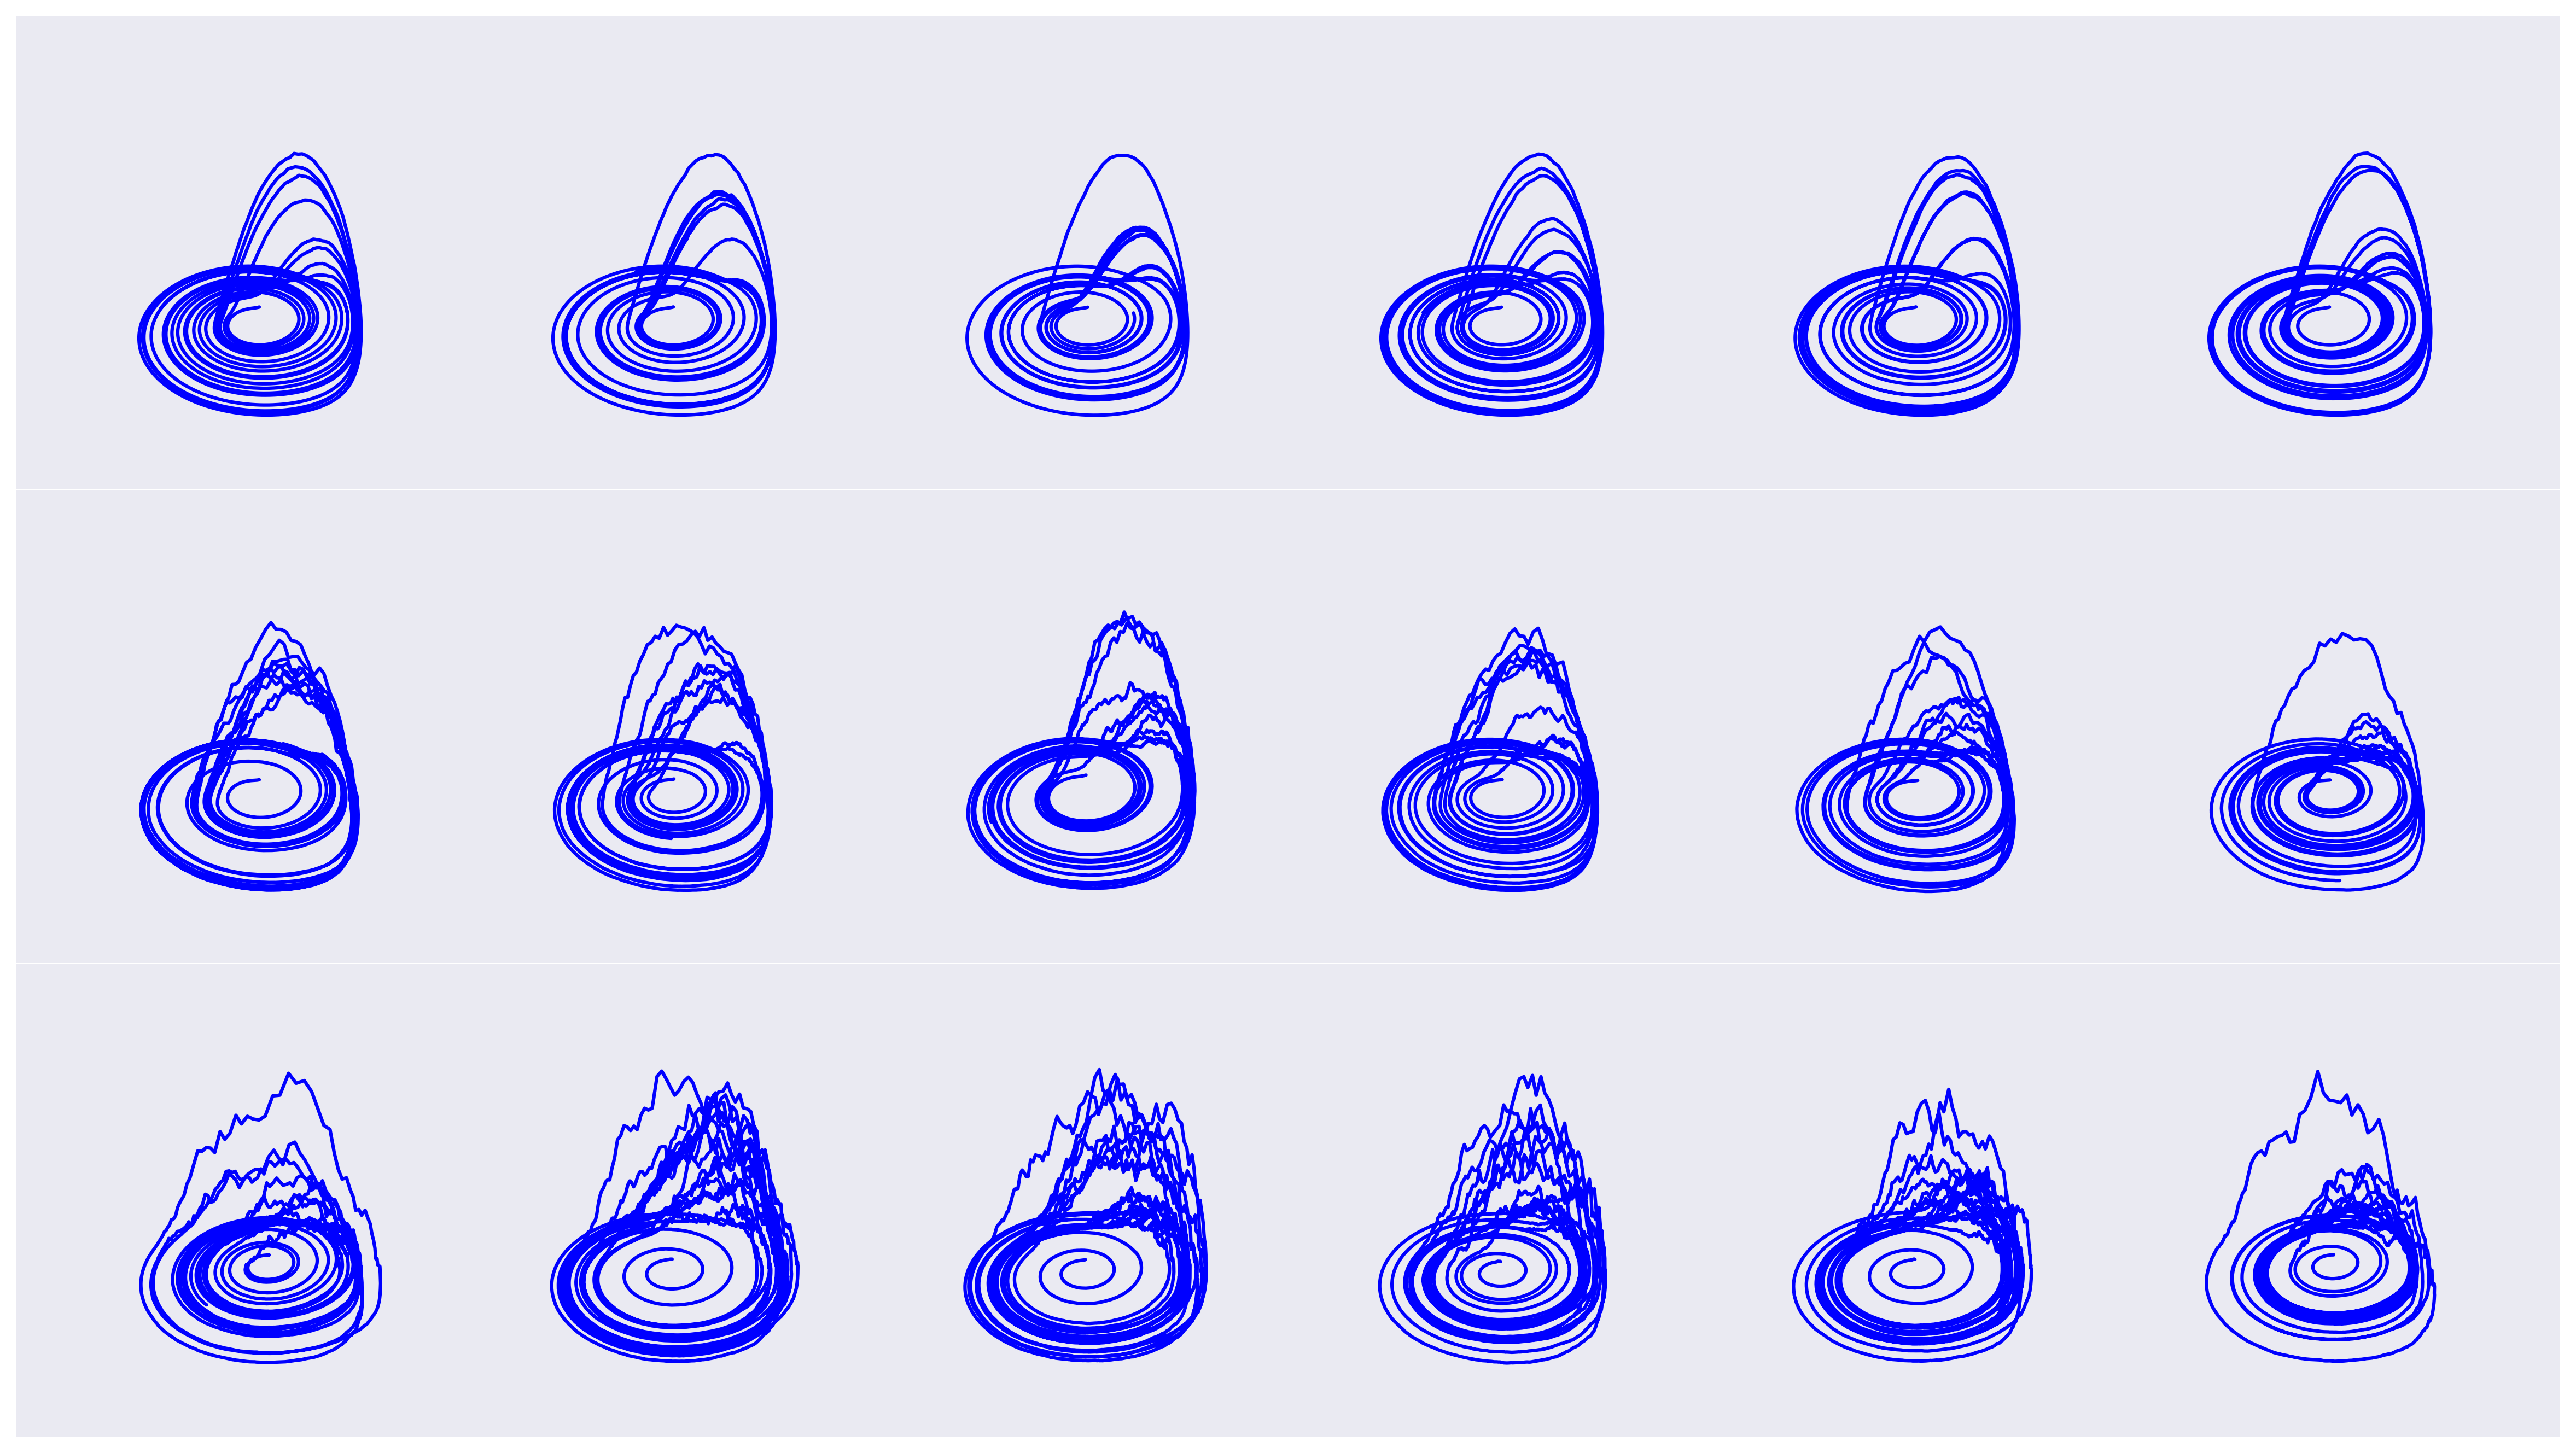

In [9]:
plot_samples(samples, 6, 300, (20, 20), "../results/app_rossler")